# SOMPZ
### The purpose of this notebook is to take a wide, deep and balrog catalogs and create N(z)'s

### 1. Load packages

In [1]:
import numpy as np
import h5py
import time
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy
import pickle as pkl
import matplotlib as mpl
from astropy.coordinates import SkyCoord
from astropy import units as u
import healpy as hp
import scipy
from scipy.optimize import differential_evolution
from matplotlib.colors import LogNorm
outpath = '/project/chihway/raulteixeira/data/'
n_deep, n_wide = 64, 32
N_deep, N_wide = n_deep**2, n_wide**2
nbins = 50
zmin, zmax = 0., 2.
deltaz = (zmax-zmin)/nbins
assert ((zmin>=0) & (zmax>=zmin) & (nbins>0) & (n_deep>0) & (n_wide>0))
z_edges = np.linspace(zmin,zmax,nbins) #np.arange(zmin,zmax,deltaz)
zs = .5*np.array([z_edges[i]+z_edges[i+1] for i in range(nbins-1)])
bins_0 = [.36, .63, .86]

### 2. load functions

In [2]:
#add descriptions to functions!!!

# def hist(a):
#     '''
#     Returns the counts of each bin in a histogram of sample a (numerical list-like object)
#     '''
#     return list(np.histogram(a, bins=z_edges, density=False)[0])

def hist(group):
    '''
    Returns the counts of each bin in a histogram of sample a (numerical list-like object)
    '''
    return list(np.histogram(group.Z, bins=z_edges, density=False, weights=group.w)[0])

def flux2mag(flux):
    '''
    Converts fluxes to magnitudes
    '''
    return -2.5 * np.log10(flux) + 30

def bin_loss(bins=bins_0, n_bins=4):
    bins = np.concatenate(([0], bins, [2]))
    binned_counts = np.zeros((n_bins, N_wide))

    redshifts = (balrog_deep[['Z', 'wide_cells']][balrog_deep['Gold_Mask']])
    Zs = redshifts['Z'].values
    bin_masks = [((bins[i]<Zs) & (Zs<bins[i+1])) for i in range(n_bins)]
    bin_groups = [redshifts[bin_masks[i]].groupby('wide_cells').agg([len]) for i in range(n_bins)]
    binned_cell_idx = [np.array(bin_group.Z.index.astype(int)) for bin_group in bin_groups]
    for i in range(n_bins):
        binned_counts[i][binned_cell_idx[i]] = bin_groups[i].Z.len

    tomo_idx = []
    for i in range(n_bins):
        tomo_idx.append(np.arange(N_wide)[np.argmax(binned_counts, axis=0)==i])

    share = [np.sum(counts_wide[tomo_idx[i]]) for i in range(n_bins)]
    norm_share = share/sum(share)
    return np.sum((norm_share - 0.25)**2)

def tb_share(bins=bins_0):
    bins = np.concatenate(([0], bins, [2]))
    binned_counts = np.zeros((n_bins, N_wide))

    redshifts = (balrog_deep[['Z', 'wide_cells']][balrog_deep['Gold_Mask']])
    Zs = redshifts['Z'].values
    bin_masks = [((bins[i]<Zs) & (Zs<bins[i+1])) for i in range(n_bins)]
    bin_groups = [redshifts[bin_masks[i]].groupby('wide_cells').agg([len]) for i in range(n_bins)]
    binned_cell_idx = [np.array(bin_group.Z.index.astype(int)) for bin_group in bin_groups]
    for i in range(n_bins):
        binned_counts[i][binned_cell_idx[i]] = bin_groups[i].Z.len

    tomo_idx = []
    for i in range(n_bins):
        tomo_idx.append(np.arange(N_wide)[np.argmax(binned_counts, axis=0)==i])

    share = [np.sum(counts_wide[tomo_idx[i]]) for i in range(n_bins)]
    norm_share = share/sum(share)
    return norm_share

### 3. Load relevant catalogs (wide, deep, balrog), apply relevant cuts and add relevant columns

In [3]:
wide = pd.read_hdf(f"%s/classify_sfd98/som_metacal_all_gold_wide_32x32_full.hdf5"%outpath, key='df')
wide['COADD_OBJECT_ID']=wide['id'].astype(int)

In [4]:
deep = pd.read_hdf('%s/DES_DF_baldet_121923_64x64_cells.hdf'%outpath, key='df')
redshift_DF = pd.read_csv('/project/chihway/raulteixeira/data/deepfields_with_redshifts.csv.gz')
deep = deep.merge(redshift_DF[['ID', 'Z']], on='ID', how='left')

In [5]:
for band in list('UGRIZJH')+['KS']:
    fluxcol = f'BDF_FLUX_DERED_CALIB_{band}'
    fluxerrcol = f'BDF_FLUX_ERR_DERED_CALIB_{band}'
    
    magcol = f'BDF_MAG_DERED_CALIB_{band}'
    magerrcol = f'BDF_MAG_ERR_DERED_CALIB_{band}'

    deep[magcol]=flux2mag(deep[fluxcol])
    deep[magerrcol]=flux2mag(deep[fluxerrcol])

In [6]:
np.isfinite(deep['Z']).sum()

70077

In [7]:
with h5py.File('/project/chihway/dhayaa/DECADE/BalrogOfTheDECADE_20231216.hdf5') as f:
    ID, ids, tilename = np.array(f['ID']), np.array(f['id']), np.array(f['tilename'])
    
    flux_r, flux_i, flux_z = np.array(f['mcal_flux_noshear_dered_sfd98']).T
    flux_err_r, flux_err_i, flux_err_z = np.array(f['mcal_flux_err_noshear_dered_sfd98']).T

    # flux_err_r, flux_err_i, flux_err_z = np.array(f['mcal_flux_err_noshear']).T
    mag_r = flux2mag(flux_r)
    mag_i = flux2mag(flux_i)
    mag_z = flux2mag(flux_z)

    mcal_pz_mask = ((mag_i < 23.5) & (mag_i > 18) & 
                    (mag_r < 26)   & (mag_r > 15) & 
                    (mag_z < 26)   & (mag_z > 15) & 
                    (mag_r - mag_i < 4)   & (mag_r - mag_i > -1.5) & 
                    (mag_i - mag_z < 4)   & (mag_i - mag_z > -1.5))

    SNR     = np.array(f['mcal_s2n_noshear'])
    T_ratio = np.array(f['mcal_T_ratio_noshear'])
    T       = np.array(f['mcal_T_noshear'])
    flags   = np.array(f['mcal_flags'])
    
    #sg = np.array(f['sg_bdf'])
    fg = np.array(f['FLAGS_FOREGROUND'])
    
    g1, g2  = np.array(f['mcal_g_noshear']).T

    #Metacal cuts based on DES Y3 ones (from here: https://des.ncsa.illinois.edu/releases/y3a2/Y3key-catalogs)
    SNR_Mask   = (SNR > 10) & (SNR < 1000)
    Tratio_Mask= T_ratio > 0.5
    T_Mask     = T < 10
    Flag_Mask  = flags == 0
    #SG_Mask = (sg>=4)
    FG_Mask = (fg==0)

    Other_Mask = np.invert((T > 2) & (SNR < 30)) & np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (g1**2 + g2**2 > 0.8**2))

    Balrog_Gold_Mask = mcal_pz_mask & SNR_Mask & Tratio_Mask & T_Mask & Flag_Mask & Other_Mask #& FG_Mask #& SG_Mask
    
    true_ra, true_dec = np.array(f['true_ra']), np.array(f['true_dec'])
    detected     = np.array(f['detected'])
    d_contam_arcsec  = np.array(f['d_contam_arcsec'])
    contmask = d_contam_arcsec > 1.5
    
    data = np.array([ID, ids, tilename, true_ra, true_dec, flux_r, flux_i, flux_z, flux_err_r, flux_err_i, flux_err_z]).T
    cols = ['ID', 'id', 'tilename', 'true_ra', 'true_dec']+[f'flux_{band}' for band in 'riz']+[f'flux_err_{band}' for band in 'riz']
    balrog = pd.DataFrame(data=data, columns=cols)
    balrog['Gold_Mask'] = Balrog_Gold_Mask
    balrog['FG_Mask'] = FG_Mask
    balrog['Cont_Mask'] = contmask
    balrog['detected'] = detected
    balrog['wide_cells'] = np.load("%s/som_BalrogoftheDECADE_121923_32x32.npz"%outpath)['cells']
# add balrog dr3_1_1 footprint cut

print(f'fraction of uncontaminated foreground balrog injections that pass the gold cut and WL selection:\
      {np.mean((balrog["Gold_Mask"])[contmask&balrog["FG_Mask"]]):.2}')

/tmp/jobs/32964388/ipykernel_254562/3711588888.py:19: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + 30
/tmp/jobs/32964388/ipykernel_254562/3711588888.py:19: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + 30
/tmp/jobs/32964388/ipykernel_254562/2423557793.py:15: RuntimeWarning: invalid value encountered in subtract
  (mag_r - mag_i < 4)   & (mag_r - mag_i > -1.5) &
/tmp/jobs/32964388/ipykernel_254562/2423557793.py:16: RuntimeWarning: invalid value encountered in subtract
  (mag_i - mag_z < 4)   & (mag_i - mag_z > -1.5))
/tmp/jobs/32964388/ipykernel_254562/2423557793.py:36: RuntimeWarning: divide by zero encountered in log10
  Other_Mask = np.invert((T > 2) & (SNR < 30)) & np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (g1**2 + g2**2 > 0.8**2))
/tmp/jobs/32964388/ipykernel_254562/2423557793.py:36: RuntimeWarning: invalid value encountered in log10
  Other_Mask = np.invert((T > 2) & (SNR < 30)) & np.invert((np.log

fraction of uncontaminated foreground balrog injections that pass the gold cut and WL selection:      0.22


In [8]:
#balrog.to_hdf('%sBalrogOfTheDECADE_20231216_wide_cells.hdf5'%outpath, key='hdf')

In [9]:
balrog_clean = balrog[balrog['Cont_Mask']&balrog["FG_Mask"]]

In [10]:
balrog_deep = balrog_clean.merge(deep, on='ID', how='left') # merge balrog w/ deep catalog for later
                                                      # will have same length as barlog catalog

deep_columns = list(deep.columns)
deep_columns.remove('deep_cells')

missing_cells = np.arange(N_deep)[~np.isin(np.arange(N_deep), balrog_deep['deep_cells'])]
n_missing_cells = len(missing_cells)
for i in range(n_missing_cells):
    balrog_deep.loc[len(balrog_deep)+i]=\
    [np.nan if col in cols+deep_columns\
     else (0. if col!='deep_cells' else missing_cells[i]) for col in balrog_deep.columns]

In [11]:
balrog_deep['Gold_Mask'] = balrog_deep['Gold_Mask'].astype(bool)

In [12]:
balrog_deep = balrog_deep[np.isfinite(balrog_deep['deep_cells'])]

### Tomography

In [13]:
#p(\hat{c}) - i.e. probability that a galaxy in the wide fields will belong to a cell c 
square_p_c_hat = wide[['COADD_OBJECT_ID', 'wide_cells']].groupby('wide_cells').agg([len])
counts_wide = square_p_c_hat.COADD_OBJECT_ID.len
#p^W(\hat{c}) - Wide field version
p_c_hat = counts_wide.values.reshape(n_wide,n_wide)
p_c_hat = p_c_hat/np.sum(p_c_hat)

In [14]:
counts_wide.sum()

108904669

In [15]:
# %%time
# bins_0 = np.random.normal([0.358, 0.631, 0.872], scale=.1)


# result_DE = differential_evolution(bin_loss, bounds=[(0,2), (0,2), (0,2)], x0=bins_0)
# bins = result_DE.x
# print(result_DE)

[0.     0.3639 0.6143 0.8558 2.    ]


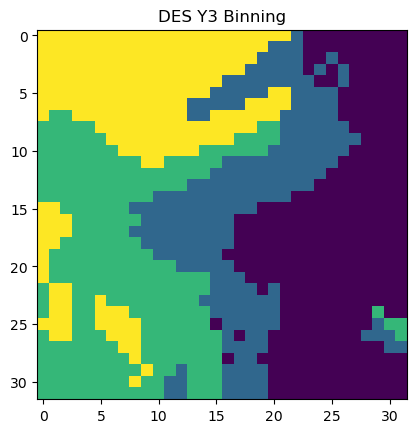

In [16]:
n_bins = 4
N_wide=32**2
Wide_bins = np.zeros(N_wide, dtype = int).flatten()
bins = np.concatenate(([0], [  3.639e-01,  6.143e-01,  8.558e-01], [2]))
binned_counts = np.zeros((n_bins, N_wide))

catalog = balrog_deep[['Z', 'wide_cells']][balrog_deep['Gold_Mask'].astype(bool)]
Zs = catalog['Z']

for i in range(N_wide):
    Balrog_in_this_cell = catalog['wide_cells'].values == i
    redshift_in_this_cell = catalog['Z'].values[Balrog_in_this_cell] #Deep/true Redshift of all gals in this cell
    bcounts_in_this_cell  = np.histogram(redshift_in_this_cell, bins)[0] #How many deep galaxy counts per z-bin
    Wide_bins[i]          = np.argmax(bcounts_in_this_cell) #Which bin is most populated by galaxies from this cell?

print(bins)
plt.title('DES Y3 Binning')
plt.imshow(Wide_bins.reshape(n_wide, n_wide))

In [17]:
# tomo_bins_wide_cells = []
# for i in range(4):
#     tomo_bins_wide_cells.append(np.arange(N_wide)[Wide_bins==i])

# import pickle
# with open('%s/tomo_bins_wide_cells.pickle'%outpath, 'wb') as handle:
#     pickle.dump(tomo_bins_wide_cells, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
wide['TomoBin'] = -99*np.ones(len(wide))
for i in range(4):
    wide['TomoBin'][np.isin(wide['wide_cells'], np.arange(0, N_wide)[Wide_bins==i])]=i
(wide['TomoBin']==-99).any()

/tmp/jobs/32964388/ipykernel_254562/3808902298.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wide['TomoBin'][np.isin(wide['wide_cells'], np.arange(0, N_wide)[Wide_bins==i])]=i
/tmp/jobs/32964388/ipykernel_254562/3808902298.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wide['TomoBin'][np.isin(wide['wide_cells'], np.arange(0, N_wide)[Wide_bins==i])]=i
/tmp/jobs/32964388/ipykernel_254562/3808902298.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

False

In [19]:
#wide[['id', 'TomoBin']].to_hdf('%s/DR3_1_ID+TomoBin.hdf5'%outpath, key='df')

### contaminant cut (moved to where the balrog cat. is loaded)

### estimating the probability of a given galaxy in the deep fields making a detection
* Note here that we are obtaining 'counts_dec' not with 'detected' column but with gold cut (double check this is correct!)

In [20]:
unique_ids, counts_true = np.unique(balrog.ID.values, return_counts=True) 
# how many injections for each DF galaxy were made

unique_ids_detected, counts_detected = np.unique(balrog.ID.values[balrog.Gold_Mask.values], return_counts=True)
# how many gold "detections" for each DF galaxy were made

# pandas to simplify life
df0 = pd.DataFrame()
df0['ID'] = unique_ids
df0['counts_ins'] = counts_true

df1 = pd.DataFrame()
df1['ID'] = unique_ids_detected
df1['counts_dec'] = counts_detected

df_ = df0.merge(df1, on='ID', how='left') 
# merge on id, this dataframe, df_, will have length equal to 
# the number of DF galaxies being used for balrog injections

df_['counts_dec'][np.isnan(df_['counts_dec'])] = 0 # !!! check if this is needed, 
                                                   # I can probably do this on the array to not get a warning

df_['p_pass'] = df_['counts_dec']/df_['counts_ins'] 
#p(\hat{c}) i.e., probability of passing for a given DF galaxy

balrog = balrog.merge(df_[['ID', 'p_pass']], on='ID') 
# merging to have everything under balrog and be able
# to make cell statistics of the columns generated in this cell

/tmp/jobs/32964388/ipykernel_254562/1835501245.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['counts_dec'][np.isnan(df_['counts_dec'])] = 0 # !!! check if this is needed,


### Create and marginalize probabilities to obtain Balrog Transfer Matrix

In [21]:
# !!!

# *Relevant* for this cell: section 5 and Appendix D in Myles, Alarcon, et. al 2021

#p(c) - i.e. probability that a galaxy in the deep fields will belong to a cell c
square_len_deep = balrog_deep[['BDF_FLUX_DERED_CALIB_I', 'deep_cells']].groupby('deep_cells').agg(['mean', 'median', 'std', len])
counts_deep = square_len_deep.BDF_FLUX_DERED_CALIB_I.len
p_c = (counts_deep/counts_deep.sum()).values.reshape(n_deep,n_deep)

#square_wide = wide['wide_cells'].groupby('wide_cells').agg(['mean', 'median', 'std', len])

#p(\hat{c}) - i.e. probability that a galaxy in the wide fields will belong to a cell c 
square_p_c_hat = wide[['COADD_OBJECT_ID', 'wide_cells']].groupby('wide_cells').agg([len])
counts_wide = square_p_c_hat.COADD_OBJECT_ID.len

In [22]:
#p(c,\hat{c}) - joint probability of a galaxy in balrog_deep being in cell c and \hat{c}

unique_ids, index, rev_index, counts_true =\
np.unique(balrog_deep.ID.values, return_counts=True, return_index=True, return_inverse=True)

InjDF = pd.DataFrame({'ID': balrog_deep.ID.values, # Credit: Alex Alarcon 
'wide_cell': balrog_deep.wide_cells.values,        # You can display this dataframe to see what it is,
'deep_cell': balrog_deep.deep_cells.values,        # but in a nutshell, it will tell you how many times
'N_inj':counts_true[rev_index],
'w':1/counts_true[rev_index],
'Z': balrog_deep.Z.values})                                     # a given DF galaxy (see 'ID' column) was injected into
                                                          # the footprint
p_cchat = np.zeros((N_wide, N_deep)) # Credit: Alex Alarcon 
np.add.at(p_cchat, (InjDF.wide_cell.values[balrog_deep.Gold_Mask.values].astype(int),\
                    InjDF.deep_cell.values[balrog_deep.Gold_Mask.values].astype(int)), 1.0 /\
          InjDF.N_inj.values[balrog_deep.Gold_Mask.values]) # what this should do:

#p^B(\hat{c}) - Balrog version - see if detection masking is appropriate here 
                                # that is, should we include this or not? [balrog.detected.values.astype(bool)]
square_p_c_hat_bal = InjDF[balrog_deep.Gold_Mask.values].groupby('wide_cell').sum('w')

counts_wide_bal = square_p_c_hat_bal['w']

p_c_hat_bal = counts_wide_bal.values.reshape(n_wide,n_wide).astype(np.float64)
p_c_hat_bal /= np.sum(p_c_hat_bal)

# get the joint c, c_hat probability as 
# p(c, c_hat) = (number of detections)/(number_injections) 
# for all injections falling into each pair (c, c_hat)
p_cchat /= np.sum(p_cchat)
#p(c)p(\hat{c})
p_c_p_c_hat = np.multiply.outer(p_c_hat_bal.flatten(), p_c.flatten())
#(p_c.flatten() * np.repeat(p_c_hat_bal, n_deep**2).reshape(n_deep**2, n_wide**2).T)
#p_c horizontal and p_c_hat vertical

balrog_term = p_cchat/np.where(p_c_p_c_hat>0, p_c_p_c_hat, 1)
#np.save('/project/chihway/raulteixeira/data/BalrogTerm_v02_10022023.npy', balrog_term)

In [23]:
np.savez('%s/p_c_hat_bal_01092023.npz'%outpath, p_c_hat_bal=p_c_hat_bal)
np.savez('%s/p_cchat_bal_01092023.npz'%outpath, p_cchat=p_cchat)

In [24]:
np.allclose(np.sum(p_cchat, axis=1), p_c_hat_bal.flatten())

True

### $p(z|\hat{c}) = \sum_{c} p(z|c) p(c) \dfrac{p(c,\hat{c})}{p(c)p(\hat{c})} p(\hat{c})$

In [25]:
#cell weights
joint_cell_weight  = p_c.flatten() * balrog_term #* p_c_hat.flatten()[:,None]
norm_jcw = np.sum(joint_cell_weight, axis=1)[:,None]
joint_cell_weight = joint_cell_weight/np.where(norm_jcw>0, norm_jcw, 1)
#p(z,c)
cell_z = InjDF[balrog_deep.Gold_Mask.values][['Z', 'deep_cell', 'w']].groupby('deep_cell').apply(func=hist)
#w_c = InjDF[['deep_cell', 'w']].groupby('deep_cell').sum('w') #w is 1/Ninj, not lensing/shear weights
p_z_c = np.array([(cell_z[int(cell)] if cell in cell_z.index else np.zeros(nbins-1)) for cell in np.arange(N_deep)])

zero_mask = np.sum(p_z_c, axis=1)==0
rangedeep = np.arange(0, n_deep**2)
#nonzero_indices = rangedeep[~zero_mask]

#p_z_c = p_z_c[nonzero_indices].astype('float64')
p_z_c = p_z_c.astype('float64')
p_z_c_norm_factor = np.sum(p_z_c, axis=1)[:,None]
p_z_c = p_z_c/np.where(p_z_c_norm_factor>0, p_z_c_norm_factor, 1)

#inner sum result of eq. 14 in Myles, Alarcon
#p_z_c_hat = (joint_cell_weight[:,nonzero_indices]@p_z_c) #check if should be normalized
p_z_c_hat = (joint_cell_weight@p_z_c) #check if should be normalized

#p_z_c_hat /= np.sum(p_z_c_hat, axis=1)[:,None]
p_z_c_hat/=np.sum(p_z_c_hat, axis=1)[:,None]

### Binning algorithm described in Myles, Alarcon 2021

In [26]:
n_bins = 4
cell_masks = [Wide_bins==i for i in range(n_bins)]

p_z_c_hat_bins = np.array([np.sum((p_c_hat.flatten()[:,None]*p_z_c_hat)[cell_masks[i]], axis=0) for i in range(n_bins)])

print('mean z per bin', [np.sum(p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i]) * zs)\
       for i in range(n_bins)])

mean z per bin [0.3565529781197664, 0.5314058809036902, 0.717883559194579, 0.8995529552824718]


In [27]:
for i in range(3):
    cov = np.sum(p_z_c_hat_bins[i]*p_z_c_hat_bins[i+1])/np.sum(p_z_c_hat_bins[i])/np.sum(p_z_c_hat_bins[i+1])
    print(f'cov between bin {i} and {i+1}: {cov:.3}')

cov between bin 0 and 1: 0.0506
cov between bin 1 and 2: 0.0353
cov between bin 2 and 3: 0.0394


In [28]:
p_z_c_hat_bins/=np.sum(p_z_c_hat_bins, axis=1)[:,None]

In [29]:
p_z_bhat_dhayaa = np.load('/project/chihway/dhayaa/DECADE/For_Raul/p_z_given_bhat_V3.npy')

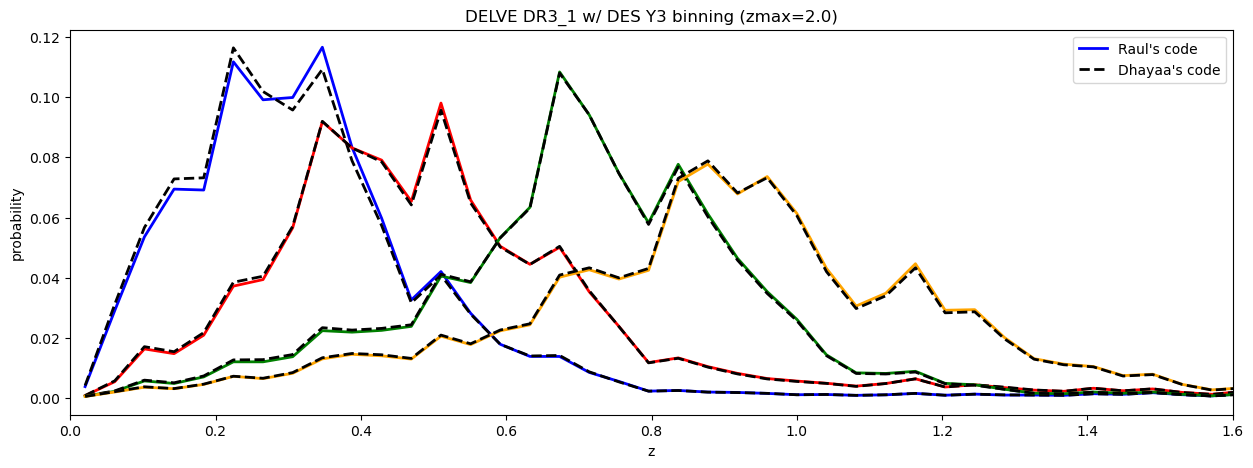

In [30]:
plt.figure(figsize=(15,5))
plt.title(f'DELVE DR3_1 w/ DES Y3 binning (zmax={zmax})')
plt.xlabel('z')
#plt.yscale('log')
plt.ylabel('probability')
colors = ['blue', 'red', 'green', 'orange']
plt.xticks(ticks=np.arange(0, 1.9, 0.2))
plt.xlim(0,1.6)
for i in range(n_bins):
    plt.plot(zs, p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i]), c=colors[i], lw=2, label='Raul\'s code' if i == 0 else None)
    plt.plot(zs, p_z_bhat_dhayaa[i], c='k', lw=2, ls='--', label='Dhayaa\'s code' if i == 0 else None)
plt.legend()
plt.show()

In [37]:
pz_b_and_zs = np.zeros((5, zs.shape[0]))
pz_b_and_zs[0] = zs
pz_b_and_zs[1:] = p_z_c_hat_bins

In [45]:
np.savetxt('%s/p_z_bins_DR3_1_011223_with_zs.txt'%outpath, pz_b_and_zs)

In [27]:
#np.savez('%s/p_z_bins_DR3_1_010923.npz'%outpath, p_z_bins=p_z_c_hat_bins)

In [28]:
print('%s/p_z_bins_DR3_1_010923.npz'%outpath)

/project/chihway/raulteixeira/data//p_z_bins_DR3_1_010923.npz


In [46]:
'%s/p_z_bins_DR3_1_011223_with_zs.txt'%outpath

'/project/chihway/raulteixeira/data//p_z_bins_DR3_1_011223_with_zs.txt'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


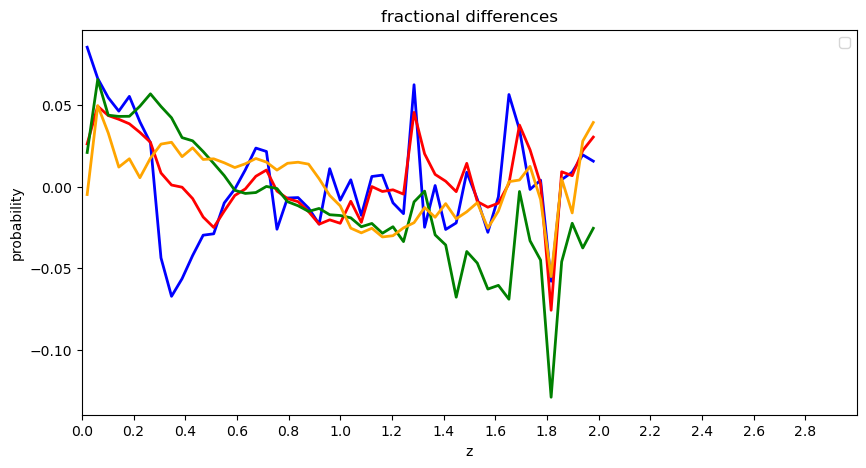

In [31]:
plt.figure(figsize=(10,5))
plt.title(f'fractional differences')
plt.xlabel('z')
#plt.yscale('log')
plt.ylabel('probability')
colors = ['blue', 'red', 'green', 'orange']
plt.xticks(ticks=np.arange(0, 3., 0.2))
plt.xlim(0,3.)
for i in range(n_bins):
    plt.plot(zs, (p_z_bhat_dhayaa[i]-(p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i])))/(p_z_bhat_dhayaa[i]), c=colors[i], lw=2, label='Raul\'s code' if i == 5 else None)
    #plt.plot(zs, p_z_bhat_dhayaa[i], c='k', lw=2, ls='--', label='Dhayaa\'s code' if i == 0 else None)
plt.legend()

In [306]:
np.save('%s/p_z_c_hat_bins_12142023.npy'%outpath, p_z_c_hat_bins)

In [307]:
print('%s/p_z_c_hat_bins_12142023.npy'%outpath)

/project/chihway/raulteixeira/data//p_z_c_hat_bins_12142023.npy


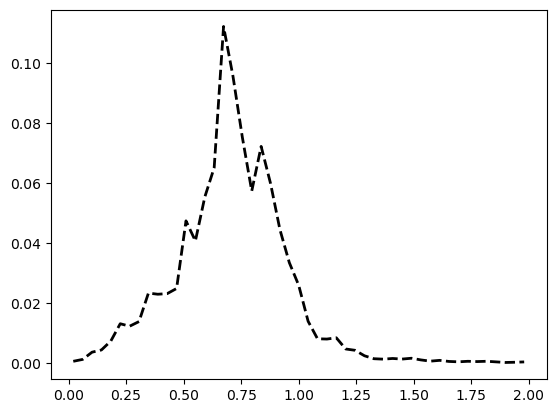

In [264]:
plt.plot(zs, p_z_bhat_dhayaa[2], c='k', lw=2, ls='--')

In [46]:
np.savetxt('%sp_z_c_hat_120823.txt'%outpath, p_z_c_hat_bins)

In [83]:
p_z_c.shape

(2302, 49)

In [59]:
'%s/p_z_c_hat_112823.txt'%outpath

'/project/chihway/raulteixeira/data//p_z_c_hat_112823.txt'

In [49]:
[f'{share:.4}' for share in tb_share(bins=result_DE.x)]

['0.25', '0.25', '0.25', '0.25']

### Deep2Wide plots (sanity checks!)

In [69]:
def group_i_deep(i, max_d, n):
    ps = np.array(np.unravel_index(np.arange(0,n**2), (n,n), order='F'))
    p = np.array(np.unravel_index(i, (n,n), order='F'))
    d = np.sum(np.abs(ps-p[:, None]),axis=0)
    return np.arange(0,n**2)[d<=max_d]

In [70]:

fig, axes = plt.subplots(nx, ny, figsize=(12, 24))
i_deeps = np.random.randint(0,n_deep**2, (nx, ny))
for i_deep in i_deeps:

    idx_deep = group_i_deep(i_deep, max_d=2, n=n_deep)

    plt.title(f'Deep SOM cell: {i_deep-1}')

    im = np.sum(p_cchat[:,idx_deep],axis=1).reshape(n_wide,n_wide)

    im /= np.sum(im)

    plt.title(f'Deep SOM cell: {i_deep-1}')
    plt.imshow(im, norm=mpl.colors.LogNorm())
    plt.colorbar()
    plt.show()

NameError: name 'nx' is not defined

In [1]:
import h5py
catpath = '/project/chihway/dhayaa/DECADE/BalrogOfTheDECADE_20231216.hdf5'
with h5py.File(catpath) as f:
    for key in f.keys():
        print(key)

Ag_planck13
Ag_sfd98
Ai
Ai_planck13
Ai_sfd98
Ar
Ar_planck13
Ar_sfd98
Az
Az_planck13
Az_sfd98
FLAGS_FOREGROUND
ID
IMAFLAGS_i
IMAFLAGS_r
IMAFLAGS_z
Ncutouts_raw
Truth_ind
Z
Z_SOURCE
badfrac
d_arcsec
d_contam_arcsec
dec
detected
id
inj_class
mcal_FLUX_i
mcal_FLUX_i_ERR
mcal_FLUX_i_ERR_dered_planck13
mcal_FLUX_i_ERR_dered_sfd98
mcal_FLUX_i_dered_planck13
mcal_FLUX_i_dered_sfd98
mcal_FLUX_r
mcal_FLUX_r_ERR
mcal_FLUX_r_ERR_dered_planck13
mcal_FLUX_r_ERR_dered_sfd98
mcal_FLUX_r_dered_planck13
mcal_FLUX_r_dered_sfd98
mcal_FLUX_z
mcal_FLUX_z_ERR
mcal_FLUX_z_ERR_dered_planck13
mcal_FLUX_z_ERR_dered_sfd98
mcal_FLUX_z_dered_planck13
mcal_FLUX_z_dered_sfd98
mcal_T_1m
mcal_T_1p
mcal_T_2m
mcal_T_2p
mcal_T_err_1m
mcal_T_err_1p
mcal_T_err_2m
mcal_T_err_2p
mcal_T_err_noshear
mcal_T_noshear
mcal_T_ratio_1m
mcal_T_ratio_1p
mcal_T_ratio_2m
mcal_T_ratio_2p
mcal_T_ratio_noshear
mcal_flags
mcal_flux_1m
mcal_flux_1m_dered_planck13
mcal_flux_1m_dered_sfd98
mcal_flux_1p
mcal_flux_1p_dered_planck13
mcal_flux_1p_d